In [1]:
import sys
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
tt = torch.tensor
from torch.nn.functional import softmax
import pyro
from pyro.distributions import Binomial, Normal, Bernoulli, Categorical, LogNormal, Poisson, Exponential, Uniform
from pyro.ops.stats import hpdi
import networkx as nx
import arviz as az

from pyro.infer import TracePosterior, TracePredictive, Trace_ELBO, Predictive

#torch.multiprocessing.set_sharing_strategy("file_system")
from utils import (
    HPDI,
    WAIC,
    sample_posterior,
    unnest_samples,
    sample_prior,
    format_data,
    train_nuts,
    traceplot,
    trankplot,
    plot_intervals,
    precis,
)
from models import RegressionBase

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Aug 25 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

arviz     : 0.17.1
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
numpy     : 1.26.4
torch     : 2.3.0
pyro      : 1.9.1
pandas    : 2.2.2
networkx  : 3.1
matplotlib: 3.9.0

Watermark: 2.4.3



In [3]:
def inv_logit(x):
    return torch.exp(x)/(1+torch.exp(x))

### Code 11.55 - 11.59
The binomial distribution does a good job of modeling binary outcomes, but what if we have more then two? The natural generalization to this is the _multinomial_ distribution,
$$
Pr(y_1, \cdots, y_K|n, p_1, \cdots, p_K) = \frac{n!}{\prod_i y_i!} \prod_{i=1}^{K} p_i^{y_i}
$$
This typically uses the multinomial logit (aka softmax) as its inverse link function:
$$Pr(k|s_1, s_2, \cdots, s_K) = \frac{\exp(s_k)}{\sum_{i=1}^{K} \exp(s_i)}$$
Typically this kind of distribution is much more difficult to reason about since there are so many more comparisons we can perform between predictions for various classes.

Let's create a simulated example where we are trying to model the effect of income on career choice. There can be multiple types of careers to choose from, each with varying levels of income.

In [4]:
# simulate career choices among 500 individuals
N = 500 # number of individuals
income = tt([1,2,5]) # expected income of each career
score = 0.5*income # scores for each career, based on income
p = softmax(score, dim=0) # scores to probabilities
print(p)
# simulate choices
career = Categorical(probs=p).sample([N])

tensor([0.0996, 0.1643, 0.7361])


In [5]:
data = {"career": career}

def model_m10_16(data, training=True): 
    b = pyro.sample("b", Normal(0., 5.))
    s2 = 2*b
    s3 = 5*b
    p = softmax(torch.stack([b, s2, s3]), dim=0)
    pyro.sample("career", Categorical(p), obs=data["career"])
    
m10_16 = train_nuts(model_m10_16, data, 3000, 3000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 6000/6000 [00:04, 1267.87it/s, step size=1.12e+00, acc. prob=0.909]


In [6]:
m10_16.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.48      0.03      0.48      0.44      0.53   1046.29      1.00

Number of divergences: 0


Hmm, from the seed data we started with, we should expect $b$ to be near 1. But 1 falls far outside this posterior. What's going on? Well, it turns out that the softmax function actually has a hidden degree of freedom. If we shift all the scores by any arbitrary value $\sigma$ like $s_k \rightarrow s_k + \sigma$, then we get
$$
\begin{align}
\text{softmax}(\vec{s} + \sigma) &= \frac{\exp(s_k + \sigma)}{\sum_i \exp(s_i + \sigma)} 
= \frac{\exp(s_k) \exp(\sigma)}{\sum_i \exp(s_i) \exp(\sigma)} \\
&= \frac{\exp(\sigma) \exp(s_k)}{\exp(\sigma) \sum_i \exp(s_i)} 
= \frac{\exp(s_k)}{\sum_i \exp(s_i)} \\
&= \text{softmax}(\vec{s})
\end{align}
$$
So the actual value of $b$ shouldn't matter at all? The only thing that does matter is the relative differences of the logits.

In [7]:
_b = m10_16.get_samples()["b"]
_p = softmax(torch.stack([_b, 2*_b, 5*_b]).T, dim=1)

In [8]:
p

tensor([0.0996, 0.1643, 0.7361])

In [9]:
precis(unnest_samples({"p": _p.numpy()}), 0.89)

,mean,stddev,5.5%,94.5%
p[0],0.105598,0.009189,0.091514,0.120331
p[1],0.170652,0.010014,0.155018,0.186426
p[2],0.72375,0.019201,0.693243,0.753468


The inference looks pretty spot-on when looking at the probabilities after softmax transformation. What if we want to look at the effect of family income on career choice? Then the predictor is the same for every score rather than being related to the career itself.

In [10]:
N = 500
# simulate family incomes for each individual
family_income = torch.rand(N)
# income have different impact for each type of event
b = tt([-2, 0, 2])
score = 0.5*tt([1, 2, 3]) + b*family_income[:,None]
p = softmax(score, dim=1)
career = Categorical(p).sample()
print(p.mean(dim=0))

tensor([0.0619, 0.1871, 0.7510])


There are no intercepts in the simulation above. But if income doesn’t predict career choice, you still want an intercept to account for differences in frequency.

In [11]:
data = {"career": career, "family_income": family_income}

def model_m10_17(data, training=True):
    a = pyro.sample("a", Normal(0., 10.).expand([2]).to_event(1))
    b = pyro.sample("b", Normal(0., 10.).expand([2]).to_event(1))
    s1 = a[0] + b[0]*data["family_income"]
    s2 = a[1] + b[1]*data["family_income"]
    #s3 = a[2] + b[2]*data["family_income"]#torch.zeros_like(s2)
    s3 = torch.zeros_like(s2)
    p = softmax(torch.stack([s1, s2, s3]), dim=0).T
    pyro.sample("obs", Categorical(p), obs=data["career"])
    
m10_17 = train_nuts(model_m10_17, data, 6000, 6000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 12000/12000 [00:40, 293.12it/s, step size=3.90e-01, acc. prob=0.924]


In [12]:
pd.DataFrame(data).sample(10)

,career,family_income
7,2,0.926600
264,1,0.630395
230,2,0.896559
493,2,0.240996
346,2,0.205933
473,2,0.797687
175,2,0.949362
134,1,0.235552
208,2,0.931834
39,2,0.848298


In [13]:
m10_17.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.72      0.31     -0.71     -1.18     -0.19   2823.18      1.00
      a[1]     -0.51      0.22     -0.51     -0.86     -0.15   2433.46      1.00
      b[0]     -5.39      1.06     -5.34     -7.10     -3.68   2841.89      1.00
      b[1]     -2.33      0.48     -2.32     -3.09     -1.54   2550.85      1.00

Number of divergences: 0


In [14]:
a = m10_17.get_samples()["a"].mean(dim=0)
b = m10_17.get_samples()["b"].mean(dim=0)
a, b

(tensor([-0.7195, -0.5142]), tensor([-5.3912, -2.3308]))

In [15]:
b = tt([b[0], b[1], 0])
score_ = tt([a[0], a[1], 0]) + b*family_income[:,None]
p_ = softmax(score_, dim=1)
print(p.mean(dim=0))
print(p_.mean(dim=0))

tensor([0.0619, 0.1871, 0.7510])
tensor([0.0606, 0.1671, 0.7724])


### Code 11.60 - 11.63
A strange trick that we can use to make certain inferences easier, is that a multinomial/categorial distribution can be modeled as the joint distribution of multiple Poissons. The conversion technique is that the event probabilities $p_i$ in the categorical distribution can be written as a normalized version of the Poisson average count $p_i = \lambda_i/\sum_j \lambda_j$. Let's look at the UC Berkeley data again and train two separate models for the overall rejection rate (forget about the department-level intricacies for now).

In [16]:
ucb_df = pd.read_csv("data/UCBadmit.csv", sep=";")
d = ucb_df.copy()
data = {
    "reject": tt(d["reject"].values).double(),
    "admit": tt(d["admit"].values).double(),
    "apps": tt(d["applications"].values).long()
}

In [17]:
def m_binom(data, training=True):
    a = pyro.sample("a", Normal(0., 1.5))
    p = inv_logit(a)
    pyro.sample("admit", Binomial(data["apps"], p), obs=data["admit"])
    
def m_pois(data, training=True):
    a1 = pyro.sample("a1", Normal(0., 1.5))
    a2 = pyro.sample("a2", Normal(0., 1.5))
    lambda1 = torch.exp(a1)
    lambda2 = torch.exp(a2)
    pyro.sample("admit", Poisson(lambda1), obs=data["admit"])
    pyro.sample("reject", Poisson(lambda2), obs=data["reject"])
    
m_binom = train_nuts(m_binom, data, 1000, 1000, 1)
m_pois = train_nuts(m_pois, data, 1000, 1000, 1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2000/2000 [00:01, 1181.36it/s, step size=9.00e-01, acc. prob=0.931]


{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2000/2000 [00:02, 810.47it/s, step size=8.55e-01, acc. prob=0.927]


In [18]:
# probability of admittance from binomial model
s = m_binom.get_samples()
precis({"p": inv_logit(s["a"]).numpy()})

,mean,stddev,5.5%,94.5%
p,0.387305,0.007464,0.374802,0.39869


In [19]:
# probability of admittance from poisson mixture model
s = m_pois.get_samples()
precis({"p": (s["a1"].exp()/(s["a1"].exp() + s["a2"].exp())).numpy()})

,mean,stddev,5.5%,94.5%
p,0.387687,0.007422,0.376062,0.399109


The inferred admittance rate appears exactly the same! Although the inference looks like it took a bit longer... is it really more computationally feasible?

### Code 11.62 - 11.??
This section is about censoring/survival. 

Now we will use some data to analyze the adoption rate of cats in Austin, TX. For simplicity we assume that the adoption rate depends only on whether the cat is black or not. Because some cats leave the population before they are adopted (through death/transfer/etc.) some of the data is censored. We assume that the number of days to adoption is exponentially distributed with rate $\lambda_i$, which has a probability density of
$$ p(D_i|\lambda_i) = \lambda_i \exp(-\lambda_i D_i). $$
The CDF of this distribution is the probability that a cat is adopted before some time $D_i$:
$$ \text{CDF}(D_i|\lambda_i) =  1 - \exp(-\lambda_i D_i) $$
and therefore the probability that a cat _would have been_ adopted after $D_i$ is 1 minus the CDF (the _complementary_ CDF):
$$ \text{CCDF}(D_i|\lambda_i) = \exp(-\lambda_i D_i). $$
This is proportional to an exponential distribution! Normally normalization doesn't matter for MCMC, but in this case it does since we are using TWO distributions with different normalization. The model is given by
$$
D_i | A_i = 1 \sim \text{Exponential}(\lambda_i) \\
D_i | A_i = 0 \sim \text{Exponential-CCDF}(\lambda_i) \\
\lambda_i = 1/\exp(\alpha_\text{color[i]}) \\
\alpha_\text{color[i]} \sim \text{Normal}(0, 1)
$$

In [22]:
cats_df = pd.read_csv("data/AustinCats.csv", sep=";")
cats_df["adopt"] = (cats_df["out_event"] == "Adoption").astype(int)
cats_df["days_to_event"] = cats_df["days_to_event"].astype(float)
cats_df["color_id"] = (cats_df["color"] == "Black").astype(int)
cats_df.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age,adopt,color_id
0,A730601,1.0,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7,0,0
1,A679549,25.0,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1,0,0
2,A683656,4.0,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2,1,0
3,A709749,41.0,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12,0,0
4,A733551,9.0,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1,0,0


In [23]:
class ExponentialCCDF(pyro.distributions.TorchDistribution):
    """CCDF of the exponential distribution
    
    The probability is Pr(x|rate) = exp(-rate*x). Note that this is NOT a
    probability distribution, it's just a raw probability. I figured out
    how to make custom distributions by reading this forum post:
    https://forum.pyro.ai/t/am-i-using-hmc-nuts-mcmc-correctly/635/15
    """
    support = torch.distributions.constraints.positive
    has_rsample = False
    
    def __init__(self, rate):
        if isinstance(rate, torch.Tensor):
            self.rate = rate
        else:
            self.rate = tt(rate)
        super(pyro.distributions.TorchDistribution).__init__()
    
    # HACK: Only used for model initialization.
    def sample(self, sample_shape=torch.Size()):
        return tt(1.)

    def log_prob(self, value):
        return -self.rate * value
    
    @property
    def event_shape(self):
        return torch.Size()
    
    @property
    def batch_shape(self):
        self.rate.shape()

In [24]:
data = format_data(cats_df[["adopt", "days_to_event", "color_id"]], categoricals=("adopt", "color_id"))

def model_m11_14(data, training=False):
    a = pyro.sample("a", Normal(0., 1.).expand([2]).to_event(0))
    mu = pyro.deterministic("mu", torch.exp(a[data["color_id"]]))
    _lambda = 1.0/mu
    adopt = data["adopt"].bool()
    o = pyro.sample("observed", Exponential(_lambda[adopt]), obs=data["days_to_event"][adopt])
    c = pyro.sample("censored", ExponentialCCDF(_lambda[~adopt]), obs=data["days_to_event"][~adopt])

m11_14 = train_nuts(model_m11_14, data, num_warmup=1000, num_samples=3000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 4000/4000 [00:15, 250.82it/s, step size=8.31e-01, acc. prob=0.928]


In [25]:
m11_14.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      3.88      0.01      3.88      3.86      3.90   2605.84      1.00
      a[1]      4.05      0.03      4.05      4.01      4.09   2212.96      1.00

Number of divergences: 0


Good, these are the same results McElreath gets. I tried it before using the exponential distribution for both and it was different! Interesting; looks like black cats are adopted at a lower rate than others:

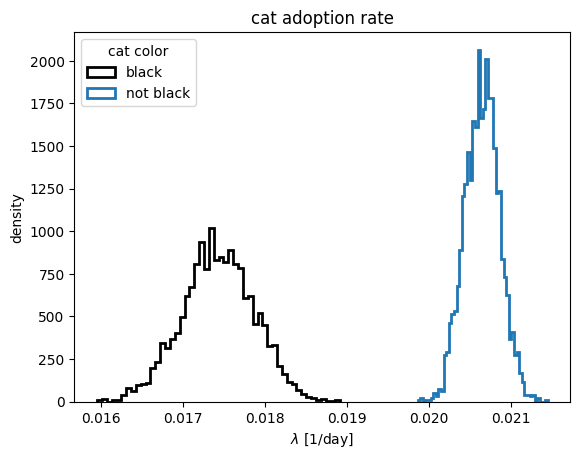

In [26]:
samples = unnest_samples(m11_14.get_samples())
plt.hist(1/samples["a[1]"].exp(), bins=50, color="black", label="black", linewidth=2, histtype="step", density=True)
plt.hist(1/samples["a[0]"].exp(), bins=50, color="C0", label="not black", linewidth=2, histtype="step", density=True)
plt.legend(title="cat color")
plt.xlabel(r"$\lambda$ [1/day]")
plt.ylabel("density")
plt.title("cat adoption rate")
plt.show()

In [27]:
samples.keys()

dict_keys(['a[0]', 'a[1]'])

In [28]:
samples["D0"] = torch.exp(samples["a[0]"]).numpy()
samples["D1"]  = torch.exp(samples["a[1]"]).numpy()
D0 = torch.exp(samples["a[0]"]).mean(dim=0).item()
D1 = torch.exp(samples["a[1]"]).mean(dim=0).item()
print(D0, D1)

samples["a[0]"] = samples["a[0]"].numpy()
samples["a[1]"] = samples["a[1]"].numpy()

# more expected number of days for black cats
precis(samples, 0.89)

48.435082575625025 57.412970321336914


,mean,stddev,5.5%,94.5%
a[0],3.880172,0.01024,3.864009,3.896969
a[1],4.049948,0.025382,4.010528,4.091374
D0,48.435083,0.49607,47.656036,49.252927
D1,57.41297,1.45968,55.17597,59.822044


Text(0, 0.5, 'Proportion Remaining')

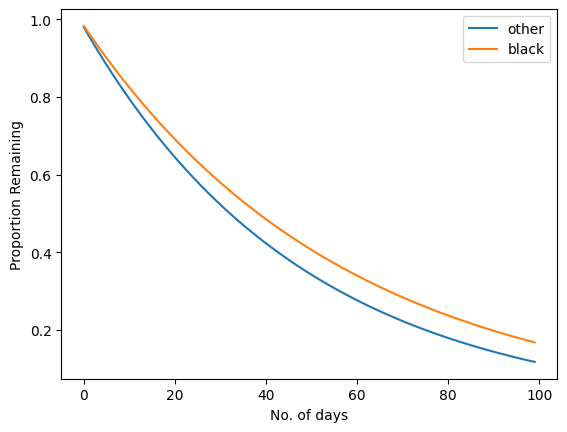

In [29]:
x = torch.arange(0, 100, 1)
D0 = Exponential(tt(1/D0)).log_prob(x).exp().numpy()
D1 = Exponential(tt(1/D1)).log_prob(x).exp().numpy()

D0 = 1 - np.cumsum(D0)
D1 = 1- np.cumsum(D1)


plt.plot(D0, label="other")
plt.plot(D1, label="black")
plt.legend()
plt.xlabel("No. of days")
plt.ylabel("Proportion Remaining")